In [23]:
from pathlib import Path
import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
from model import UNet

import multiprocessing
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

In [17]:
#helper
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index("image")] = "label"  
    return Path(*parts)

In [18]:
save_root = Path("/scratch/scratch6/akansh12/Parse_data/processed_train")

In [19]:
subjects_paths_train = list(save_root.glob("train/*/image/*"))
subject_train = []

for i in subjects_paths_train:
    label_path = change_img_to_label_path(i)
    subject = tio.Subject({"CT":tio.ScalarImage(i), "Label":tio.LabelMap(label_path)})
    subject_train.append(subject)

subjects_paths_val = list(save_root.glob("val/*/image/*"))
subject_val = []

for i in subjects_paths_val:
    label_path = change_img_to_label_path(i)
    subject = tio.Subject({"CT":tio.ScalarImage(i), "Label":tio.LabelMap(label_path)})
    subject_val.append(subject)


In [20]:
process = tio.Compose([
            tio.CropOrPad((256, 256, 200)),
            tio.RescaleIntensity((-1, 1))
            ])

augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))


val_transform = process
train_transform = tio.Compose([process, augmentation])

In [21]:
train_dataset = tio.SubjectsDataset(subject_train, transform=train_transform)
val_dataset = tio.SubjectsDataset(subject_val, transform=val_transform)

sampler = tio.data.UniformSampler(patch_size=96)

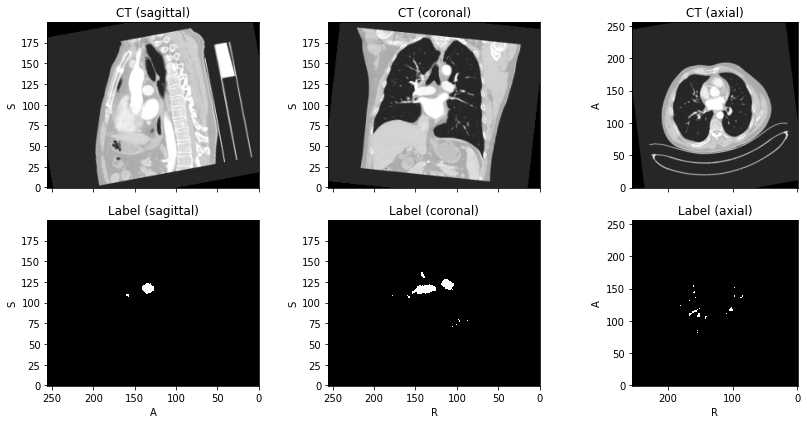

In [25]:
train_dataset[1].plot()

In [10]:
train_patches_queue = tio.Queue(
     train_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

val_patches_queue = tio.Queue(
     val_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )


In [11]:
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=batch_size, num_workers=0)


In [16]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.float()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.float()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Val Loss", loss)
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    
    def log_images(self, img, pred, mask, name):
        
        results = []
        pred = torch.argmax(pred, 1) # Take the output with the highest value
        axial_slice = 50  # Always plot slice 50 of the 96 slices
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:,:,axial_slice]==0, mask[0][:,:,axial_slice])
        axis[0].imshow(mask_[0], alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:,:,axial_slice]==0, pred[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)
            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [17]:
model = Segmenter()
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [18]:
gpus = 0 #TODO
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="/scratch/scratch6/akansh12/challenges/parse2022/notebooks/logs/"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=25)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [19]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type              | Params
----------------------------------------------
0 | model   | UNet              | 5.8 M 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.344    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/scratch/scratch6/akansh12/env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/scratch/scratch6/akansh12/env/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/scratch/scratch6/akansh12/env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have m

Training: 0it [00:00, ?it/s]

/scratch/scratch6/akansh12/env/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:686: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
